### Estimating Planetary Radii in Four Directions from Transit Light Curves of an Asymmetric Planet with Day-Night Asymmetries

In [31]:
from wasp39b_params import period_day
from calc_light_curve import transit_compute_flux_ecc0, transit_asymmetric_compute_flux
from karate.calc_contact_times import (
    calc_contact_times_circular,
)
from karate.convert_ctv import (
    contact_times_to_delta_c_ingress_circular,
    contact_times_to_delta_c_egress_circular,
    rotate_delta_c_egress_circular,
    rotate_delta_c_ingress_circular,
    dcx_to_rp_spectra,
)

import numpy as np
import matplotlib.pyplot as plt

from jax import random
from jax import config
import jax.numpy as jnp

import numpyro
from numpyro import distributions as dist
from numpyro.infer import Predictive
from numpyro.infer import MCMC, NUTS, init_to_value
from numpyro.diagnostics import hpdi

We will generate a transit light curve with the wavelength-dependent displacement of the planetary shadow. 

In [32]:
rng_key = random.key(0)
rng_key, rng_key_ = random.split(rng_key)

wavelength = np.linspace(3.0, 5.0, 21)
time = np.linspace(-150, 150, 301) * 65
rp_over_rs = 0.150 + 0.005 * jnp.sin(wavelength * jnp.pi)
t0 = 0
period = period_day * 24 * 60 * 60
a_over_rs = 11.4
ecc = 0
omega = 0
cosi = 0.45 / a_over_rs
u1 = 0.1
u2 = 0.1
jitter = 0.00025

# Center displacement
dc_over_rs_X_ingress = 0.005 * jnp.cos(wavelength * 1.6 * jnp.pi + 0.3 * jnp.pi)
dc_over_rs_Y_ingress = 0.005 * jnp.sin(wavelength * 1.5 * jnp.pi + 0.0 * jnp.pi)
dc_over_rs_X_egress = 0.005 * jnp.cos(wavelength * 2.0 * jnp.pi + 0.0 * jnp.pi)
dc_over_rs_Y_egress = 0.005 * jnp.sin(wavelength * 1.3 * jnp.pi + 0.5 * jnp.pi)

flux = transit_asymmetric_compute_flux(
        time,
        rp_over_rs,
        dc_over_rs_X_ingress,
        dc_over_rs_Y_ingress,
        dc_over_rs_X_egress,
        dc_over_rs_Y_egress,
        t0,
        period,
        a_over_rs,
        ecc,
        omega,
        cosi,
        u1,
        u2,
    )
error = jitter * random.normal(rng_key_, shape=flux.shape)
flux = flux + error

We will plot the spectra for all four directions.

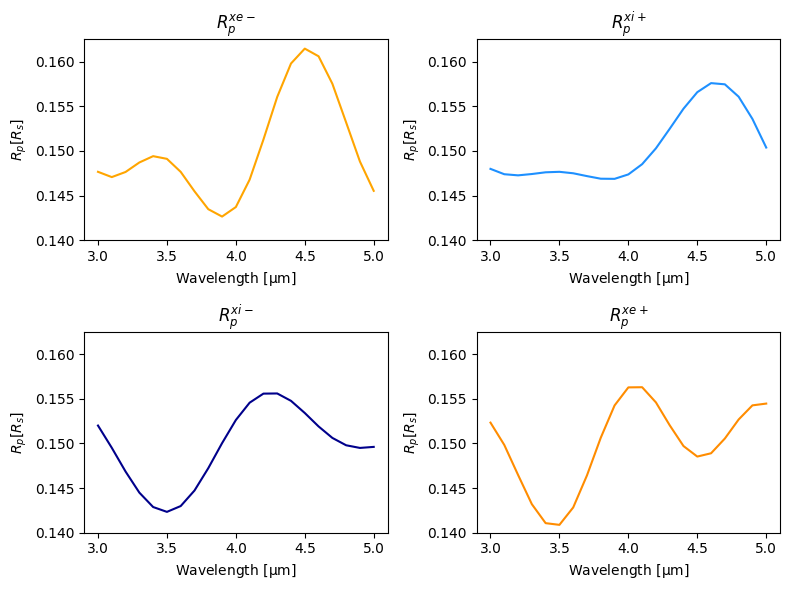

In [33]:
%matplotlib inline
dc_xi_ingress_truth, dc_yi_ingress_truth = rotate_delta_c_ingress_circular(
    dc_over_rs_X_ingress, dc_over_rs_Y_ingress, a_over_rs, cosi
)
dc_xe_egress_truth, dc_ye_egress_truth = rotate_delta_c_egress_circular(
    dc_over_rs_X_egress, dc_over_rs_Y_egress, a_over_rs, cosi
)
rp_xip_truth, rp_xin_truth = dcx_to_rp_spectra(
    rp_over_rs, dc_xi_ingress_truth, rs_alpha=1
)
rp_xep_truth, rp_xen_truth = dcx_to_rp_spectra(
    rp_over_rs, dc_xe_egress_truth, rs_alpha=1
)

rp_truth = [[rp_xen_truth, rp_xip_truth], [rp_xin_truth, rp_xep_truth]]
color = [["orange", "dodgerblue"], ["darkblue", "darkorange"]]
directions = [["$R_{p}^{xe-}$", "$R_{p}^{xi+}$"], ["$R_{p}^{xi-}$", "$R_{p}^{xe+}$"]]

fig = plt.figure(figsize=(8,6))
for i in range(2):
    for j in range(2):
        ax = fig.add_subplot(2, 2, i*2+j+1)
        ax.plot(
            wavelength,
            rp_truth[i][j],
            color=color[i][j],
        )
        ax.set_ylim(0.14, 0.1625)
        ax.set_title(directions[i][j])
        ax.set_xlabel("Wavelength [$\mathrm{\mu m}$]")
        ax.set_ylabel("$R_{p} [R_{s}]$")
plt.tight_layout()
plt.show()
plt.close()

The generated data will be fitted with a transit light curve assuming zero eccentricity using Numpyro's Hamiltonian Monte Carlo (HMC).

In [34]:
def model_ecc0(flux_obs, time, num_lightcurve):
    with numpyro.plate("n_light_curve", num_lightcurve, dim=-1):
        period = period_day * 24 * 60 * 60
        t0 = numpyro.sample("t0", dist.Uniform(-5000, 5000))
        depth = numpyro.sample("depth", dist.Uniform(0, 0.1))
        Ttot = numpyro.sample("Ttot", dist.Uniform(5000, 15000))

        theta_tot = 2 * jnp.pi * Ttot / period
        theta_full_max = 2 * jnp.arcsin(
            (1 - jnp.sqrt(depth)) / (1 + jnp.sqrt(depth)) * jnp.sin(theta_tot / 2)
        )
        Tfull_max = theta_full_max / 2 / jnp.pi * period
        Tfull = numpyro.sample("Tfull", dist.Uniform(1, Tfull_max))
        theta_full = 2 * jnp.pi * Tfull / period

        u1 = numpyro.sample("u1", dist.Uniform(-3, 3))
        u2 = numpyro.sample("u2", dist.Uniform(-3, 3))
        baseline = numpyro.sample("baseline", dist.Uniform(0.99, 1.01))
        jitter = numpyro.sample("jitter", dist.Uniform(0, 0.01))

    rp_over_rs = jnp.sqrt(depth)
    a_over_rs = jnp.sqrt(
        (
            -((1 - jnp.sqrt(depth)) ** 2) * jnp.cos(theta_tot / 2) ** 2
            + (1 + jnp.sqrt(depth)) ** 2 * jnp.cos(theta_full / 2) ** 2
        )
        / jnp.sin((theta_tot + theta_full) / 2)
        / jnp.sin((theta_tot - theta_full) / 2)
    )
    cosi = jnp.sqrt(
        (
            (1 - jnp.sqrt(depth)) ** 2 * jnp.sin(theta_tot / 2) ** 2
            - (1 + jnp.sqrt(depth)) ** 2 * jnp.sin(theta_full / 2) ** 2
        )
        / (
            -((1 - jnp.sqrt(depth)) ** 2) * jnp.cos(theta_tot / 2) ** 2
            + (1 + jnp.sqrt(depth)) ** 2 * jnp.cos(theta_full / 2) ** 2
        )
    )
    flux = transit_compute_flux_ecc0(
        time, rp_over_rs, t0, period, a_over_rs, cosi, u1, u2
    )
    with numpyro.plate("wavelength", num_lightcurve, dim=-2):
        with numpyro.plate("time", len(time), dim=-1):
            numpyro.sample(
                "light_curve",
                dist.Normal(
                    flux * baseline[:, None],
                    jitter[:, None] * jnp.ones_like(flux),
                ),
                obs=flux_obs,
            )

In [35]:
init_Ttot = (
    period
    / jnp.pi
    * jnp.arcsin(
        jnp.sqrt((1.0 + 0.15) ** 2 - (a_over_rs * cosi) ** 2)
        / jnp.sqrt(1.0 - cosi**2)
        / a_over_rs
    )
)
init_Tfull = (
    period
    / jnp.pi
    * jnp.arcsin(
        jnp.sqrt((1.0 - 0.15) ** 2 - (a_over_rs * cosi) ** 2)
        / jnp.sqrt(1.0 - cosi**2)
        / a_over_rs
    )
)
init_values = {
    "t0": t0 * jnp.ones_like(rp_over_rs),
    "Ttot": init_Ttot * jnp.ones_like(rp_over_rs),
    "Tfull": init_Tfull * jnp.ones_like(rp_over_rs),
    "depth": 0.15**2 * jnp.ones_like(rp_over_rs),
    "u1": u1 * jnp.ones_like(rp_over_rs),
    "u2": u2 * jnp.ones_like(rp_over_rs),
    "baseline": 1.0 * jnp.ones_like(rp_over_rs),
    "jitter": jitter * jnp.ones_like(rp_over_rs),
}
init_strategy = init_to_value(values=init_values)

# MCMC
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(model_ecc0, init_strategy=init_strategy)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)
mcmc.run(
    rng_key_,
    flux_obs=flux,
    time=time,
    num_lightcurve=len(flux),
)
mcmc.print_summary()

# Get samples
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [01:40<00:00, 19.98it/s, 127 steps of size 3.43e-02. acc. prob=0.86]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
    Tfull[0]   7112.44     39.86   7110.76   7043.21   7173.03    502.89      1.00
    Tfull[1]   7068.71     32.78   7070.71   7009.84   7118.59    617.91      1.00
    Tfull[2]   7114.33     33.18   7114.72   7061.73   7168.25    677.45      1.00
    Tfull[3]   7134.26     34.40   7133.60   7079.10   7188.85    510.80      1.00
    Tfull[4]   7122.84     35.37   7122.04   7061.76   7175.16    577.52      1.00
    Tfull[5]   7199.97     43.36   7199.33   7128.24   7273.39    700.83      1.00
    Tfull[6]   7143.49     39.04   7143.71   7083.19   7209.76    514.38      1.00
    Tfull[7]   7128.74     31.90   7130.32   7072.53   7177.17    634.66      1.00
    Tfull[8]   7094.33     39.04   7094.94   7031.12   7155.23    572.51      1.00
    Tfull[9]   7070.53     34.32   7071.24   7012.24   7123.13    546.58      1.00
   Tfull[10]   6996.23     36.23   6995.28   6936.79   7054.84    434.25      1.01
   

In [36]:
# Prediction
rng_key, rng_key_ = random.split(rng_key)
pred = Predictive(model_ecc0, posterior_samples)
predictions = pred(
    rng_key_,
    flux_obs=None,
    time=time,
    num_lightcurve=len(flux),
)

Example of a Fitted Light Curve

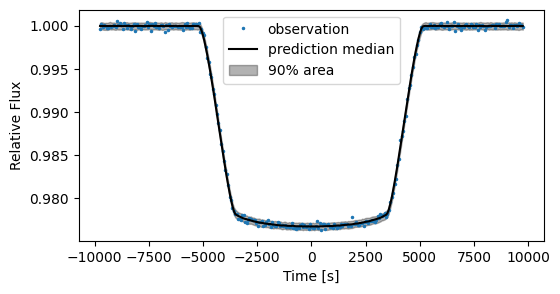

In [37]:
pred_median = np.median(predictions["light_curve"], axis=0)
pred_hpdi = hpdi(predictions["light_curve"], 0.90)

%matplotlib inline
plt.figure(figsize=(6,3))
plt.plot(
    time,
    flux[10],
    marker=".",
    markersize=3,
    linestyle="None",
    label="observation",
)
plt.plot(
    time,
    pred_median[10],
    color="black",
    label="prediction median",
)
plt.fill_between(
    time,
    pred_hpdi[0, 10],
    pred_hpdi[1, 10],
    alpha=0.3,
    interpolate=True,
    color="black",
    label="90% area",
)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Relative Flux")
plt.show()
plt.close()

From the estimated parameters, we will derive the planetary radius, the orbital semi-major axis, cos(orbital inclination), and the transit center time at each wavelength. Using these values, we will compute the contact times and convert them into the spectra of the planetary radius in four directions.

In [38]:
theta_tot = 2 * np.pi * posterior_samples["Ttot"] / period
theta_full = 2 * np.pi * posterior_samples["Tfull"] / period

sample_rp_over_rs = np.sqrt(posterior_samples["depth"])
sample_a_over_rs = np.sqrt(
    (
        -(1 - sample_rp_over_rs) ** 2 * np.cos(theta_tot / 2) ** 2
        + (1 + sample_rp_over_rs) ** 2 * np.cos(theta_full / 2) ** 2
    )
    / np.sin((theta_tot + theta_full) / 2)
    / np.sin((theta_tot - theta_full) / 2)
)
sample_cosi = np.sqrt(
    (
        (1 - sample_rp_over_rs) ** 2 * np.sin(theta_tot / 2) ** 2
        - (1 + sample_rp_over_rs) ** 2 * np.sin(theta_full / 2) ** 2
    )
    / (
        -((1 - sample_rp_over_rs) ** 2) * np.cos(theta_tot / 2) ** 2
        + (1 + sample_rp_over_rs) ** 2 * np.cos(theta_full / 2) ** 2
    )
)
sample_t1, sample_t2, sample_t3, sample_t4 = calc_contact_times_circular(
    sample_rp_over_rs, period, sample_a_over_rs, sample_cosi, posterior_samples["t0"]
)

dc_X_ingress, dc_Y_ingress = contact_times_to_delta_c_ingress_circular(
    sample_rp_over_rs,
    sample_t1,
    sample_t2,
    period,
    np.mean(np.median(sample_a_over_rs, axis=0)),
    np.mean(np.median(sample_cosi, axis=0)),
    np.mean(np.median(posterior_samples["t0"], axis=0)),
    rs_alpha=1,
)
dc_X_egress, dc_Y_egress = contact_times_to_delta_c_egress_circular(
    sample_rp_over_rs,
    sample_t3,
    sample_t4,
    period,
    np.mean(np.median(sample_a_over_rs, axis=0)),
    np.mean(np.median(sample_cosi, axis=0)),
    np.mean(np.median(posterior_samples["t0"], axis=0)),
    rs_alpha=1,
)
dc_xi_ingress, dc_yi_ingress = rotate_delta_c_ingress_circular(
    dc_X_ingress, dc_Y_ingress, a_over_rs, cosi
)
dc_xe_egress, dc_ye_egress = rotate_delta_c_egress_circular(
    dc_X_egress, dc_Y_egress, a_over_rs, cosi
)
rp_xip, rp_xin = dcx_to_rp_spectra(
    sample_rp_over_rs, dc_xi_ingress, rs_alpha=1
)
rp_xep, rp_xen = dcx_to_rp_spectra(
    sample_rp_over_rs, dc_xe_egress, rs_alpha=1
)

The number of d < rs_alpha*k (ingress) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
The number of d < rs_alpha*k (egress) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


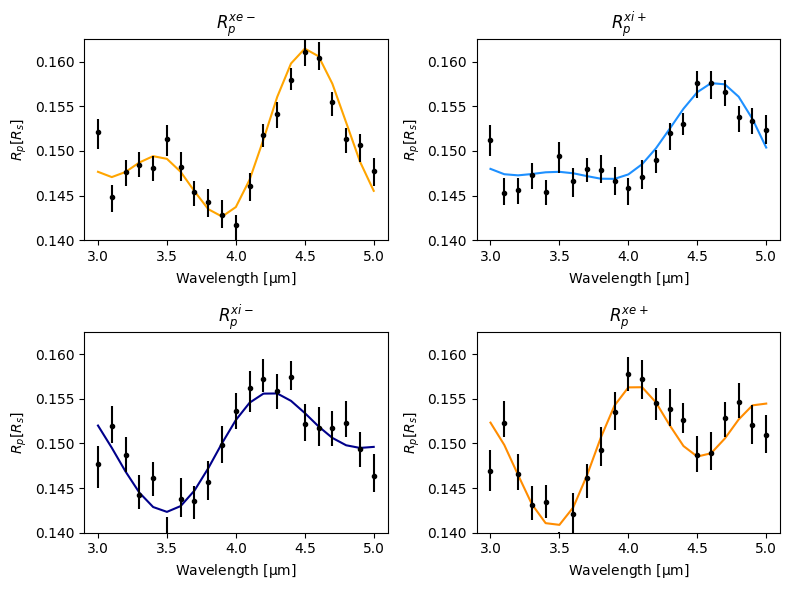

In [39]:
rp_xip_median = np.median(rp_xip, axis=0)
rp_xip_hpdi = hpdi(rp_xip, 0.68)
rp_xip_err = [rp_xip_median - rp_xip_hpdi[0], rp_xip_hpdi[1] - rp_xip_median]

rp_xin_median = np.median(rp_xin, axis=0)
rp_xin_hpdi = hpdi(rp_xin, 0.68)
rp_xin_err = [rp_xin_median - rp_xin_hpdi[0], rp_xin_hpdi[1] - rp_xin_median]

rp_xep_median = np.median(rp_xep, axis=0)
rp_xep_hpdi = hpdi(rp_xep, 0.68)
rp_xep_err = [rp_xep_median - rp_xep_hpdi[0], rp_xep_hpdi[1] - rp_xep_median]

rp_xen_median = np.median(rp_xen, axis=0)
rp_xen_hpdi = hpdi(rp_xen, 0.68)
rp_xen_err = [rp_xen_median - rp_xen_hpdi[0], rp_xen_hpdi[1] - rp_xen_median]

rp_4_median = [[rp_xen_median, rp_xip_median], [rp_xin_median, rp_xep_median]]
rp_4_err = [[rp_xen_err, rp_xip_err], [rp_xin_err, rp_xep_err]]

%matplotlib inline
fig = plt.figure(figsize=(8,6))
for i in range(2):
    for j in range(2):
        ax = fig.add_subplot(2, 2, i*2+j+1)
        ax.plot(
            wavelength,
            rp_truth[i][j],
            color=color[i][j],
        )
        ax.errorbar(
            wavelength,
            rp_4_median[i][j],
            yerr=rp_4_err[i][j],
            color="black",
            marker=".",
            linestyle="None",
        )
        ax.set_ylim(0.14, 0.1625)
        ax.set_title(directions[i][j])
        ax.set_xlabel("Wavelength [$\mathrm{\mu m}$]")
        ax.set_ylabel("$R_{p} [R_{s}]$")
plt.tight_layout()
plt.show()
plt.close()